Información básica de club_data:
<class 'pandas.core.frame.DataFrame'>
Index: 36 entries, 4 to 425
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   club_id                  36 non-null     int64  
 1   club_code                36 non-null     object 
 2   name                     36 non-null     object 
 3   domestic_competition_id  36 non-null     object 
 4   total_market_value       0 non-null      float64
 5   squad_size               36 non-null     int64  
 6   average_age              36 non-null     float64
 7   foreigners_number        36 non-null     int64  
 8   foreigners_percentage    36 non-null     float64
 9   national_team_players    36 non-null     int64  
 10  stadium_name             36 non-null     object 
 11  stadium_seats            36 non-null     int64  
 12  net_transfer_record      36 non-null     object 
 13  coach_name               0 non-null      float64
 14 

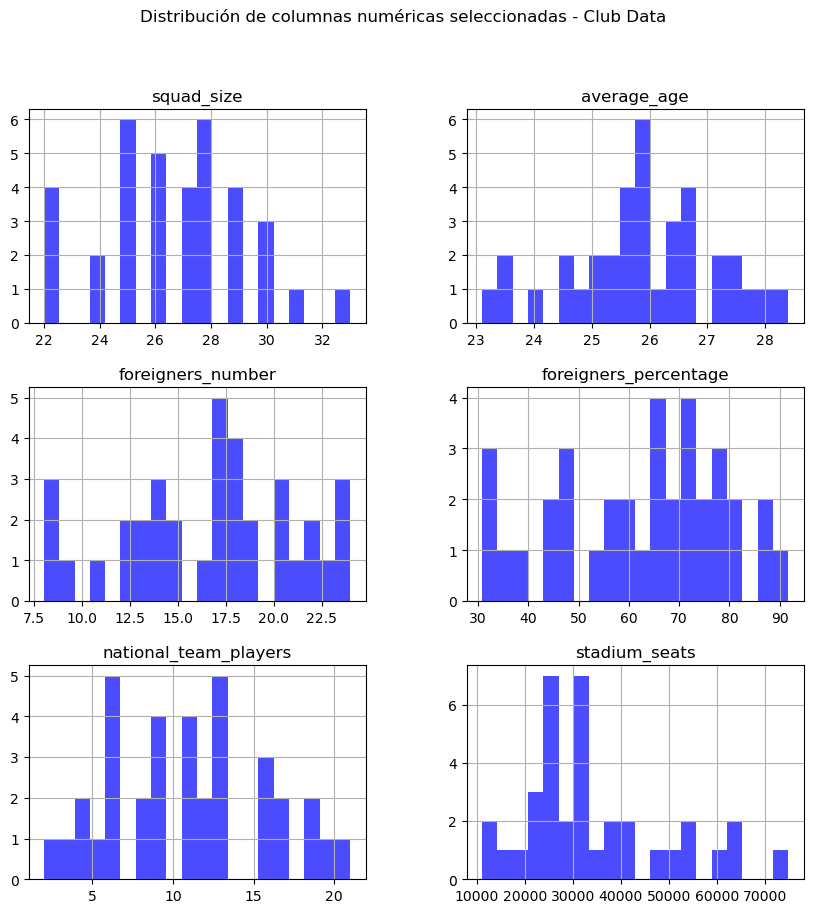

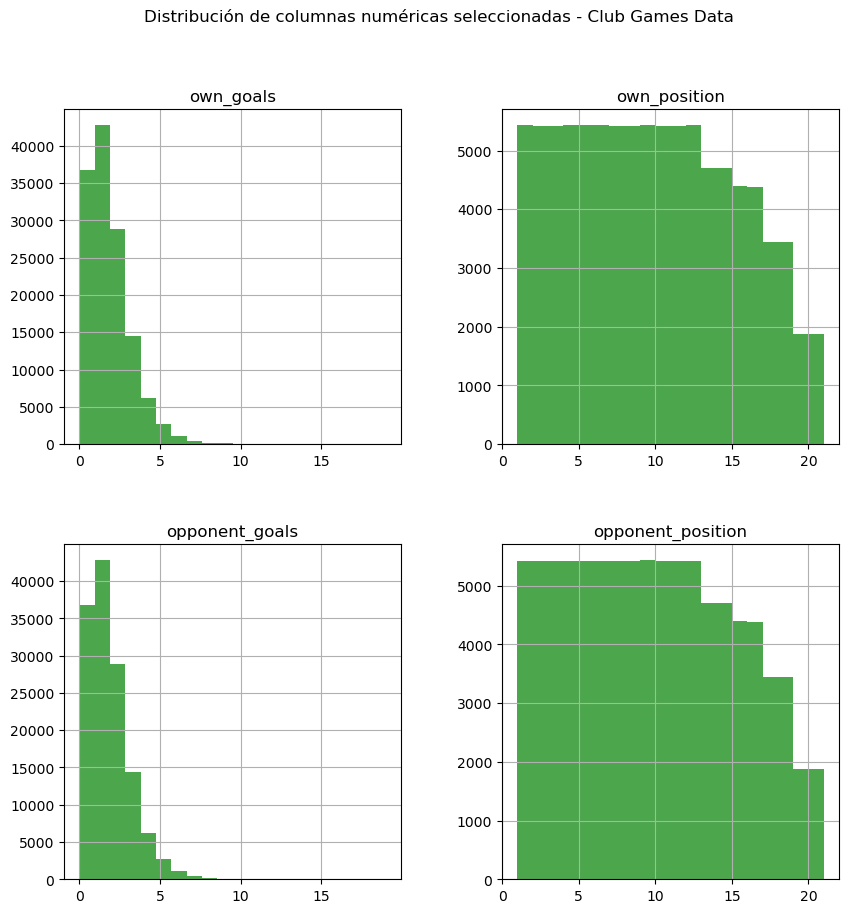

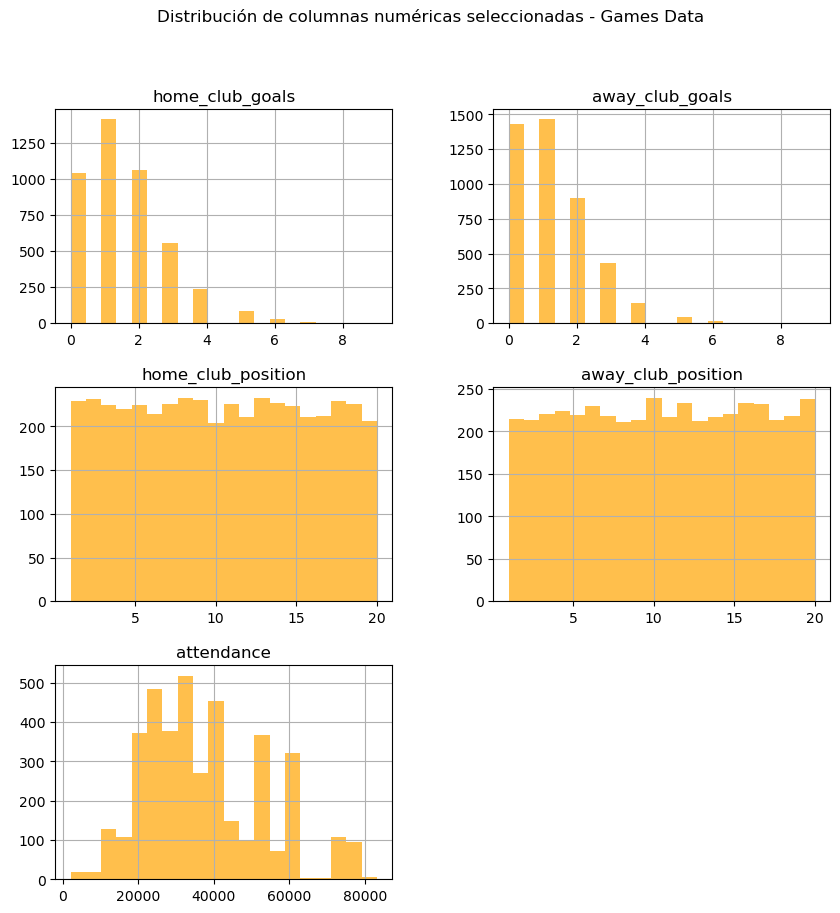


Generando gráficos de distribución para columnas categóricas...


C:\Users\ivizq\AppData\Local\Temp\ipykernel_1288\628422010.py:130: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=club_data[column], order=club_data[column].value_counts().index, palette="viridis")


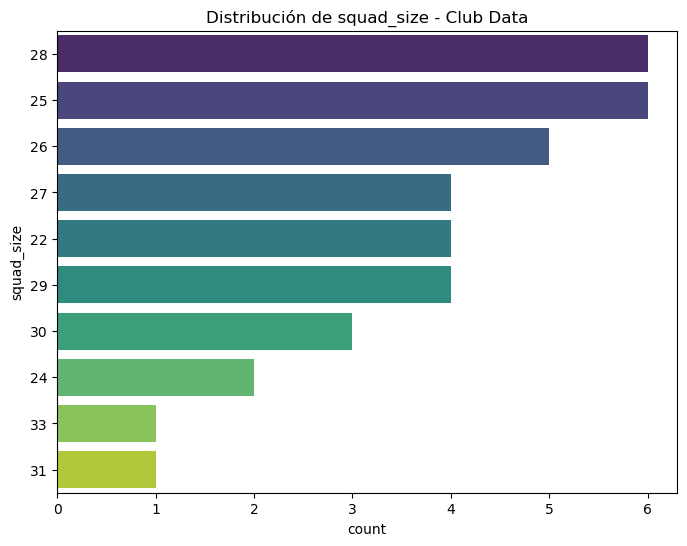

C:\Users\ivizq\AppData\Local\Temp\ipykernel_1288\628422010.py:130: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=club_data[column], order=club_data[column].value_counts().index, palette="viridis")


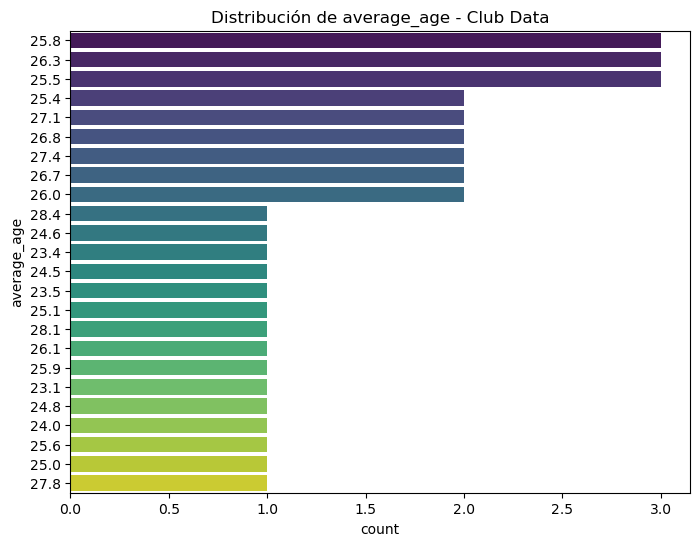

C:\Users\ivizq\AppData\Local\Temp\ipykernel_1288\628422010.py:130: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=club_data[column], order=club_data[column].value_counts().index, palette="viridis")


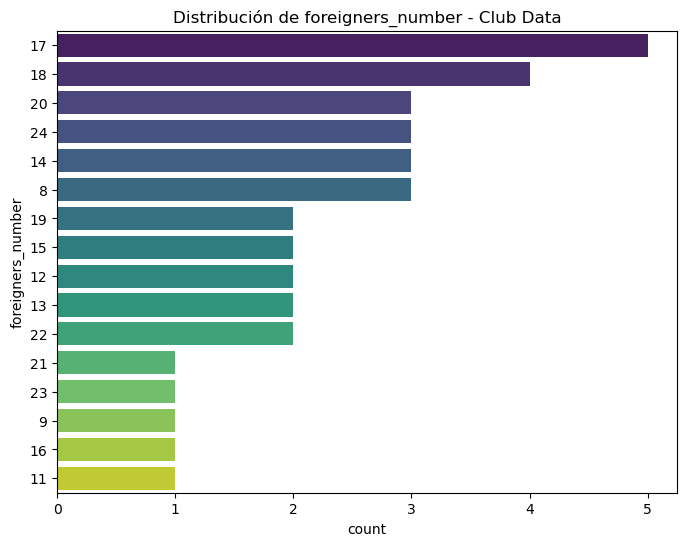

C:\Users\ivizq\AppData\Local\Temp\ipykernel_1288\628422010.py:130: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=club_data[column], order=club_data[column].value_counts().index, palette="viridis")


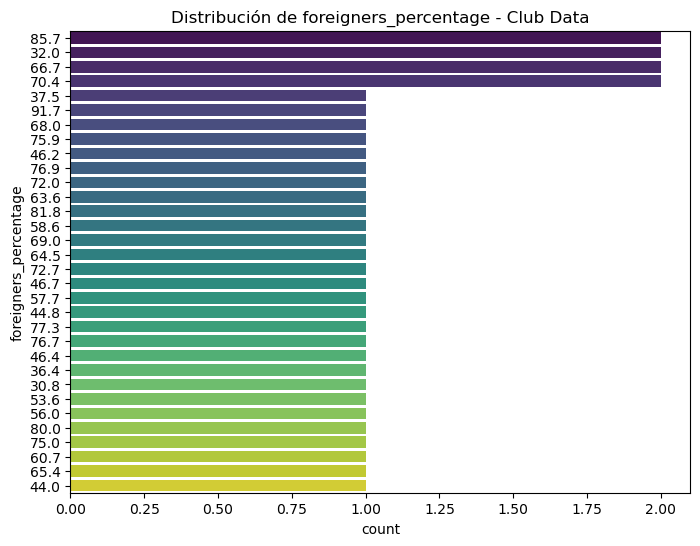

C:\Users\ivizq\AppData\Local\Temp\ipykernel_1288\628422010.py:130: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=club_data[column], order=club_data[column].value_counts().index, palette="viridis")


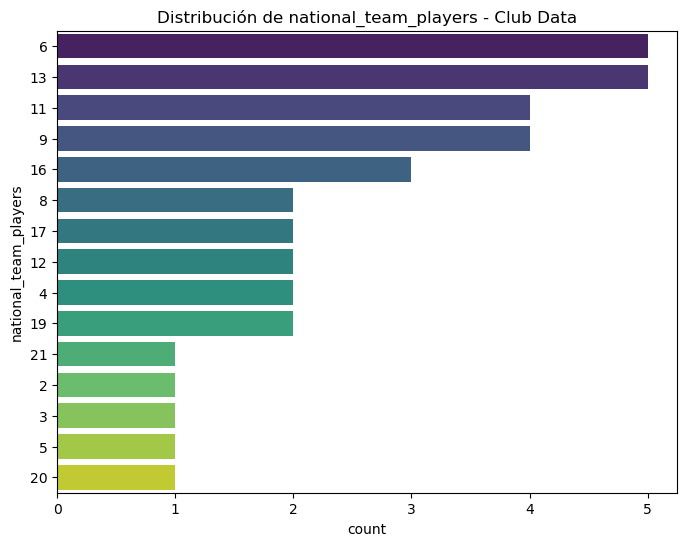

C:\Users\ivizq\AppData\Local\Temp\ipykernel_1288\628422010.py:130: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=club_data[column], order=club_data[column].value_counts().index, palette="viridis")


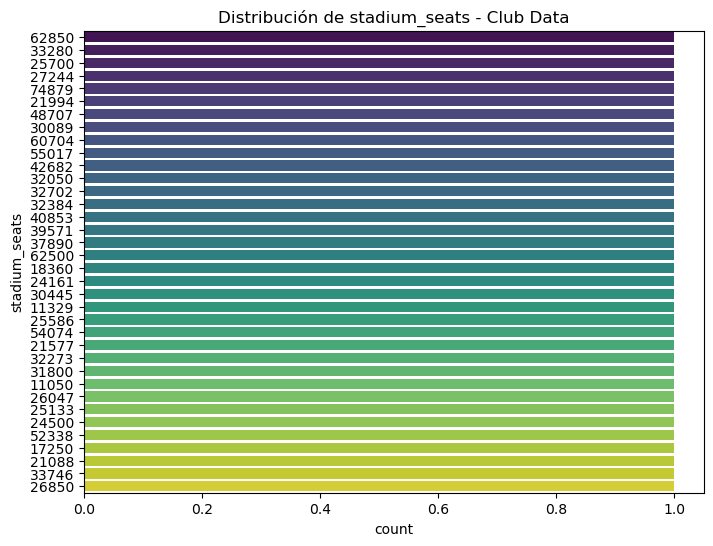

C:\Users\ivizq\AppData\Local\Temp\ipykernel_1288\628422010.py:140: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=club_games_data[column], order=club_games_data[column].value_counts().index, palette="coolwarm")


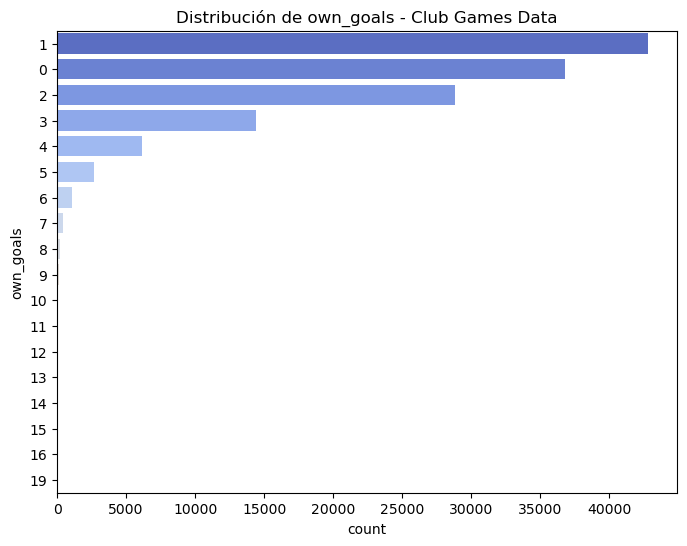

C:\Users\ivizq\AppData\Local\Temp\ipykernel_1288\628422010.py:140: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=club_games_data[column], order=club_games_data[column].value_counts().index, palette="coolwarm")


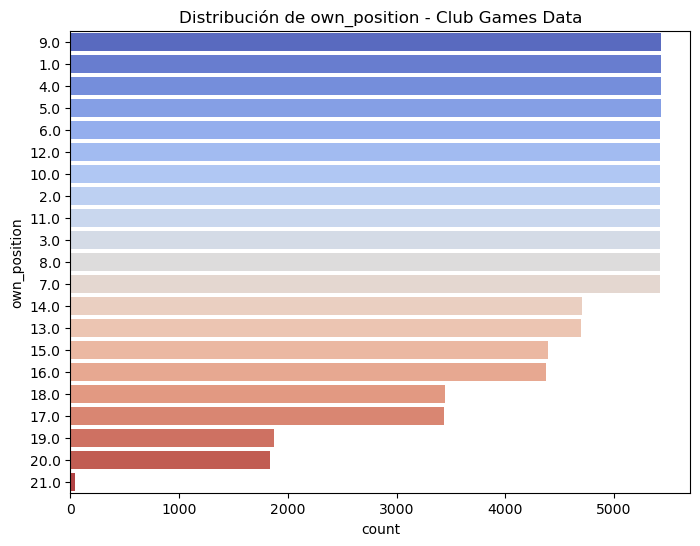

C:\Users\ivizq\AppData\Local\Temp\ipykernel_1288\628422010.py:140: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=club_games_data[column], order=club_games_data[column].value_counts().index, palette="coolwarm")


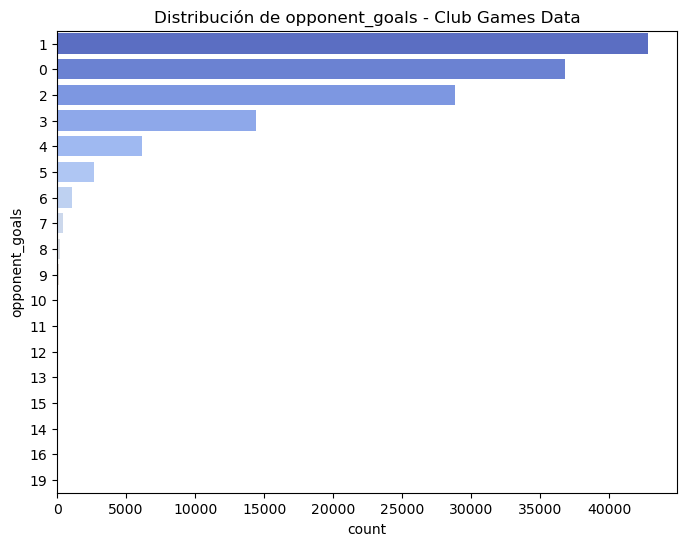

C:\Users\ivizq\AppData\Local\Temp\ipykernel_1288\628422010.py:140: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=club_games_data[column], order=club_games_data[column].value_counts().index, palette="coolwarm")


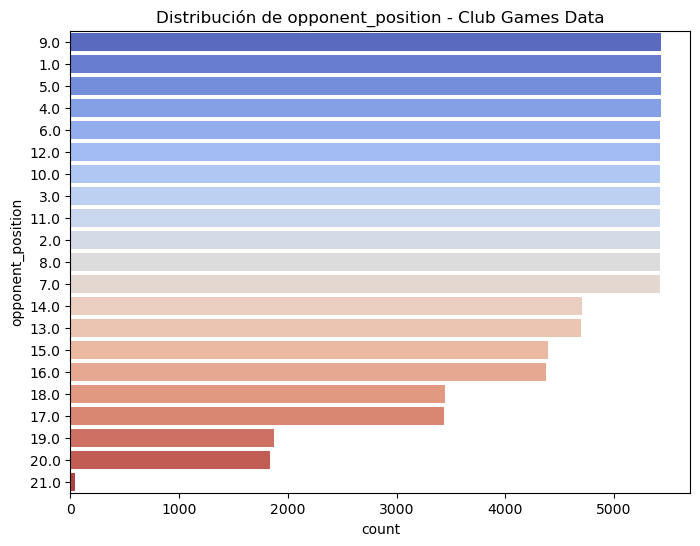

C:\Users\ivizq\AppData\Local\Temp\ipykernel_1288\628422010.py:150: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=games_data[column], order=games_data[column].value_counts().index, palette="magma")


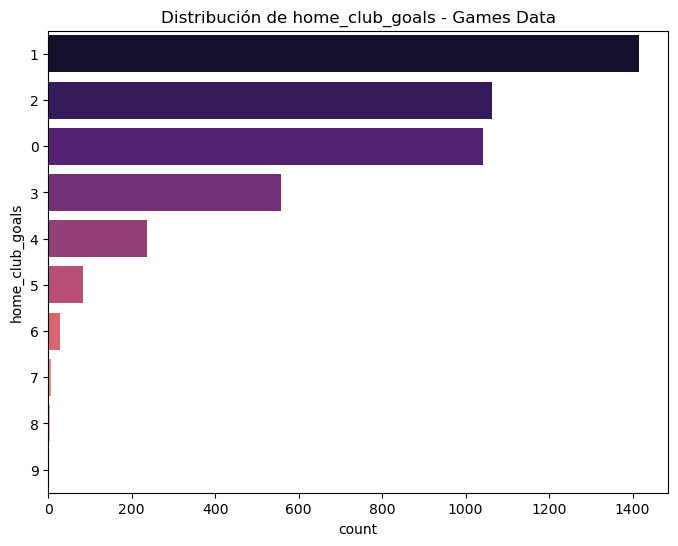

C:\Users\ivizq\AppData\Local\Temp\ipykernel_1288\628422010.py:150: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=games_data[column], order=games_data[column].value_counts().index, palette="magma")


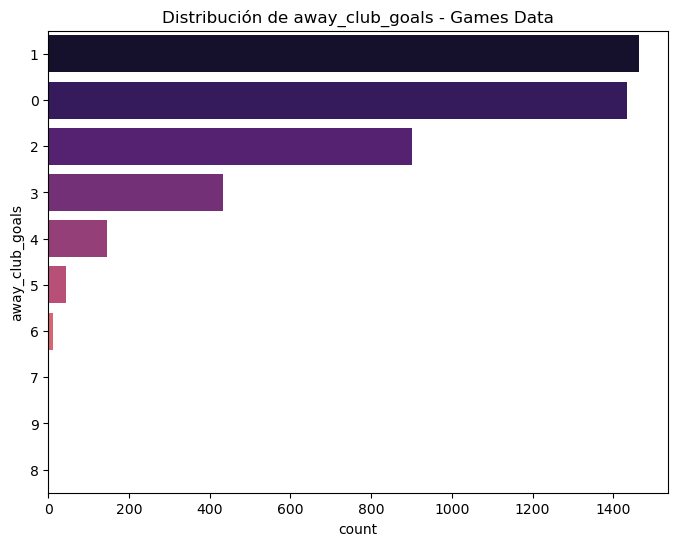

C:\Users\ivizq\AppData\Local\Temp\ipykernel_1288\628422010.py:150: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=games_data[column], order=games_data[column].value_counts().index, palette="magma")


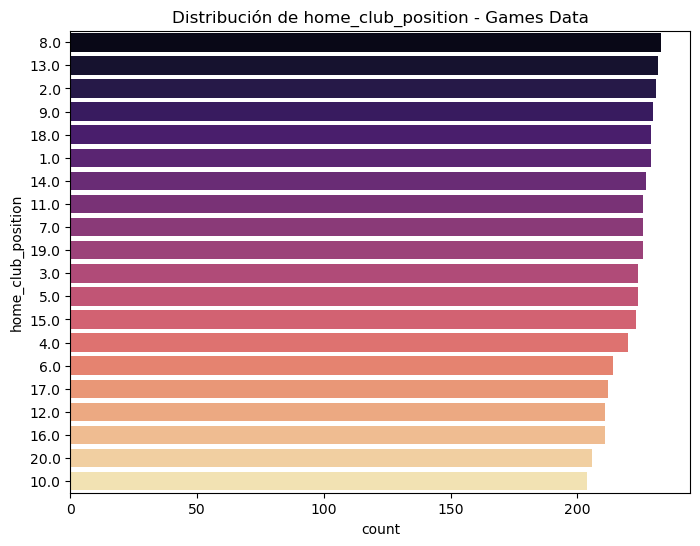

C:\Users\ivizq\AppData\Local\Temp\ipykernel_1288\628422010.py:150: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=games_data[column], order=games_data[column].value_counts().index, palette="magma")


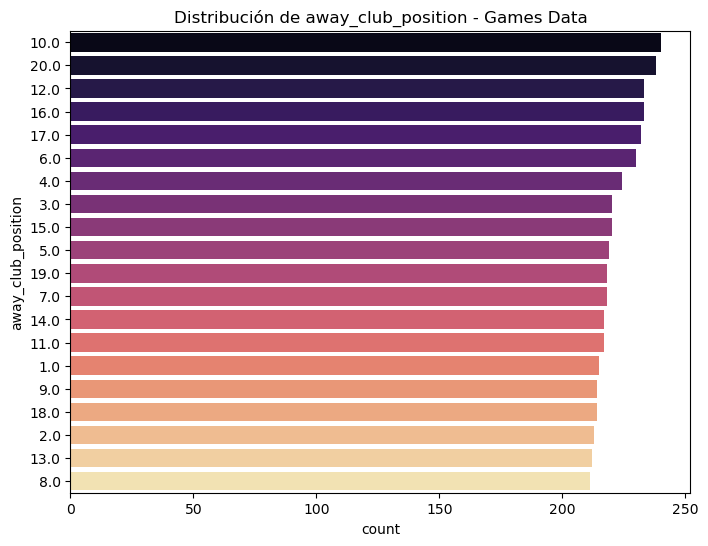

C:\Users\ivizq\AppData\Local\Temp\ipykernel_1288\628422010.py:150: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=games_data[column], order=games_data[column].value_counts().index, palette="magma")


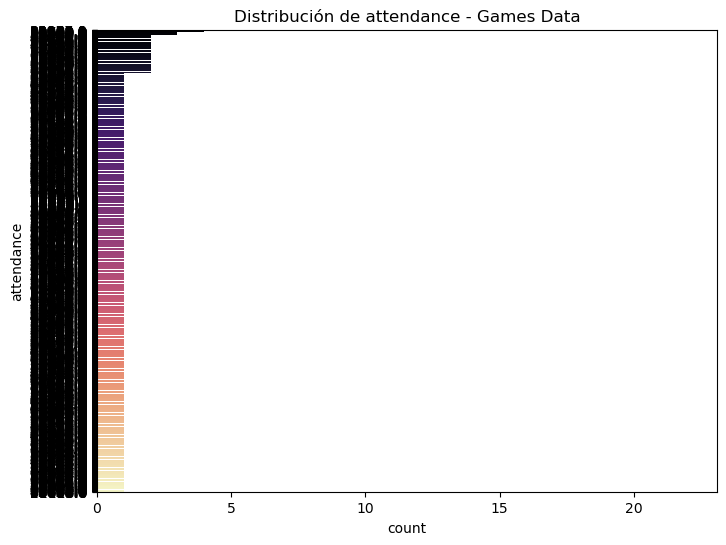

C:\Users\ivizq\AppData\Local\Temp\ipykernel_1288\628422010.py:150: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=games_data[column], order=games_data[column].value_counts().index, palette="magma")


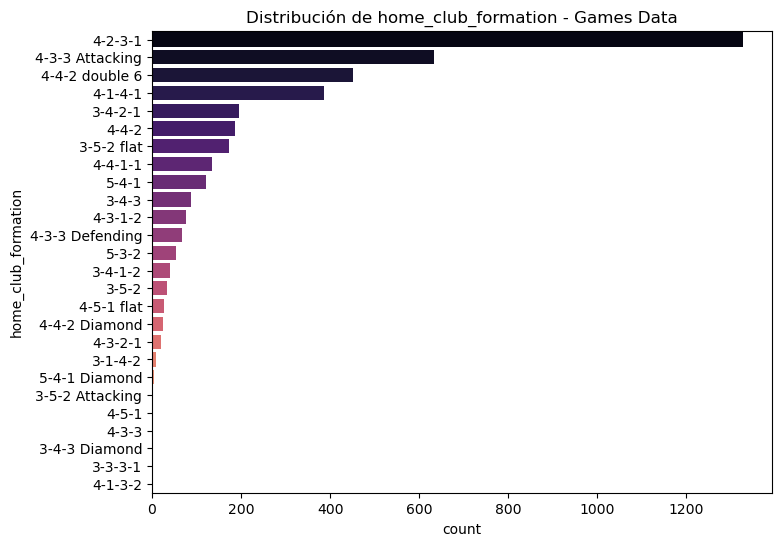

C:\Users\ivizq\AppData\Local\Temp\ipykernel_1288\628422010.py:150: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=games_data[column], order=games_data[column].value_counts().index, palette="magma")


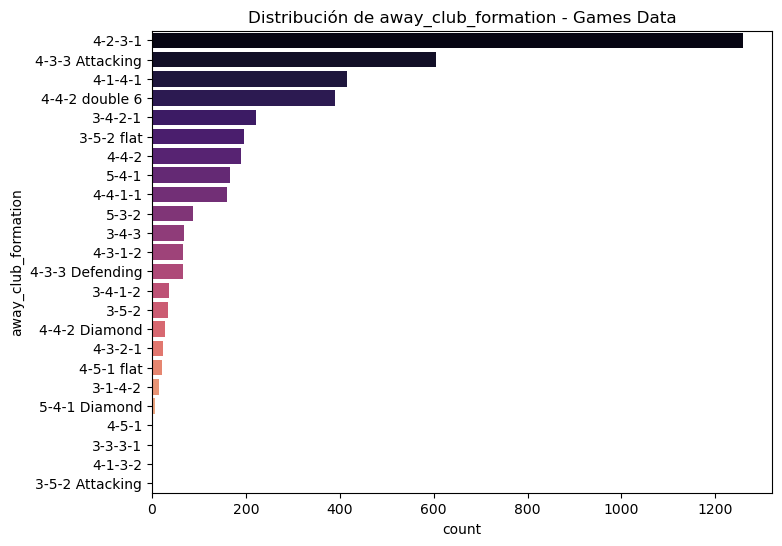

In [2]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

club_data = pd.read_csv('csv/clubs.csv')
club_games_data = pd.read_csv('csv/club_games.csv')
games_data = pd.read_csv('csv/games.csv')

games_data = games_data[(games_data['competition_id'] == 'GB1') & 
                            (games_data['competition_type'] == 'domestic_league')].copy()

club_data = club_data[club_data['domestic_competition_id'] == 'GB1'].copy()

games_data['home_club_formation'] = games_data['home_club_formation'].str.replace(r'^\D+', '', regex=True)
games_data['away_club_formation'] = games_data['away_club_formation'].str.replace(r'^\D+', '', regex=True)


print("Información básica de club_data:")
print(club_data.info())
print("\nPrimeras filas de club_data:")
print(club_data.head())

print("\nInformación básica de club_games_data:")
print(club_games_data.info())
print("\nPrimeras filas de club_games_data:")
print(club_games_data.head())

print("\nInformación básica de games_data:")
print(games_data.info())
print("\nPrimeras filas de games_data:")
print(games_data.head())

print("\nValores nulos en club_data:")
print(club_data.isnull().sum())

print("\nValores nulos en club_games_data:")
print(club_games_data.isnull().sum())

print("\nValores nulos en games_data:")
print(games_data.isnull().sum())

print("\nValores únicos y frecuencias en club_data:")
for column in club_data.columns:
    print(f"{column} - Valores únicos:")
    print(club_data[column].value_counts())
    print("\n")

print("\nValores únicos y frecuencias en club_games_data:")
for column in club_games_data.columns:
    print(f"{column} - Valores únicos:")
    print(club_games_data[column].value_counts())
    print("\n")

print("\nValores únicos y frecuencias en games_data:")
for column in games_data.columns:
    print(f"{column} - Valores únicos:")
    print(games_data[column].value_counts())
    print("\n")

print("\nColumnas comunes entre club_data y club_games_data:")
print(set(club_data.columns) & set(club_games_data.columns))

print("\nColumnas comunes entre club_games_data y games_data:")
print(set(club_games_data.columns) & set(games_data.columns))

print("\nColumnas comunes entre club_data y games_data:")
print(set(club_data.columns) & set(games_data.columns))


print("\nEstadísticas descriptivas de club_data:")
print(club_data.describe())

print("\nEstadísticas descriptivas de club_games_data:")
print(club_games_data.describe())

print("\nEstadísticas descriptivas de games_data:")
print(games_data.describe())

print("\nGenerando histogramas para columnas numéricas...")

columns_to_analyze_club_data = ['squad_size','average_age', 'foreigners_number','foreigners_percentage','national_team_players','stadium_seats']  
columns_to_analyze_club_games_data = ['own_goals', 'own_position','opponent_goals','opponent_position']  
columns_to_analyze_games_data = ['home_club_goals', 'away_club_goals','home_club_position','away_club_position','attendance','home_club_formation','away_club_formation']


if set(columns_to_analyze_club_data).issubset(club_data.columns):
    club_data[columns_to_analyze_club_data].hist(bins=20, figsize=(10, 10), color='blue', alpha=0.7)
    plt.suptitle("Distribución de columnas numéricas seleccionadas - Club Data")
    plt.show()
else:
    print("Algunas columnas seleccionadas no existen en club_data.")


if set(columns_to_analyze_club_games_data).issubset(club_games_data.columns):
    club_games_data[columns_to_analyze_club_games_data].hist(bins=20, figsize=(10, 10), color='green', alpha=0.7)
    plt.suptitle("Distribución de columnas numéricas seleccionadas - Club Games Data")
    plt.show()
else:
    print("Algunas columnas seleccionadas no existen en club_games_data.")


if set(columns_to_analyze_games_data).issubset(games_data.columns):
    games_data[columns_to_analyze_games_data].hist(bins=20, figsize=(10, 10), color='orange', alpha=0.7)
    plt.suptitle("Distribución de columnas numéricas seleccionadas - Games Data")
    plt.show()
else:
    print("Algunas columnas seleccionadas no existen en games_data.")



print("\nGenerando gráficos de distribución para columnas categóricas...")


columns_to_analyze_club_data = ['squad_size','average_age', 'foreigners_number','foreigners_percentage','national_team_players','stadium_seats'] 
columns_to_analyze_club_games_data = ['own_goals', 'own_position','opponent_goals','opponent_position']  
columns_to_analyze_games_data = ['home_club_goals', 'away_club_goals','home_club_position','away_club_position','attendance','home_club_formation','away_club_formation'] 


for column in columns_to_analyze_club_data:
    if column in club_data.columns: 
        plt.figure(figsize=(8, 6))
        sns.countplot(y=club_data[column], order=club_data[column].value_counts().index, palette="viridis")
        plt.title(f"Distribución de {column} - Club Data")
        plt.show()
    else:
        print(f"Columna {column} no encontrada en club_data.")


for column in columns_to_analyze_club_games_data:
    if column in club_games_data.columns: 
        plt.figure(figsize=(8, 6))
        sns.countplot(y=club_games_data[column], order=club_games_data[column].value_counts().index, palette="coolwarm")
        plt.title(f"Distribución de {column} - Club Games Data")
        plt.show()
    else:
        print(f"Columna {column} no encontrada en club_games_data.")


for column in columns_to_analyze_games_data:
    if column in games_data.columns:  
        plt.figure(figsize=(8, 6))
        sns.countplot(y=games_data[column], order=games_data[column].value_counts().index, palette="magma")
        plt.title(f"Distribución de {column} - Games Data")
        plt.show()
    else:
        print(f"Columna {column} no encontrada en games_data.")



